In [1]:
import sys
# print(sys.path)
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from imutils import paths


In [3]:
def showVideo(path_to_file):
    clean_video = cv2.VideoCapture(path_to_file)

    if clean_video.isOpened() == False:
        print("Error opening video stream or file")

    while clean_video.isOpened():
        ret, frame = clean_video.read()
        if ret:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cv2.destroyAllWindows()


In [4]:
def getImagesFromVideo(path_to_file, k=0):
    clean_video = cv2.VideoCapture(path_to_file)
    ret, frame = clean_video.read()
    count = 0
    while ret:
        if k == 1:
            cv2.imwrite("dataset/anomaly_images/image_anomaly_{}.jpg".format(count), frame)
        else: 
            cv2.imwrite("dataset/images/image_{}.jpg".format(count), frame)
        ret, frame = clean_video.read()
        count += 1
    print("Done reading {} frames from file {}".format(count, path_to_file))

In [5]:
def getData(path_to_file, image_size):
    imagePaths = list (paths.list_images(path_to_file))
    data = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        data.append(image)
    data = np.array(data).astype('float32') / 255.
    print("Done creating data for file {}".format(path_to_file))
    k = 0
    if k == 1:
        print(data.shape)
        cv2.imshow("data", data[0])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return data

In [6]:
def splitData(data):
    train_data, test_data = train_test_split(data, test_size = 0.2, random_state=42)
    train_data = tf.cast(train_data, tf.float32)
    test_data = tf.cast(test_data, tf.float32)

    train_data = train_data[..., tf.newaxis]
    test_data = test_data[..., tf.newaxis]

    print(train_data.shape)
    return train_data, test_data

    

In [7]:
path_video_clean_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi'
path_video_anomaly_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi'

# showVideo(path_clean_data)

getImagesFromVideo(path_video_clean_data)
getImagesFromVideo(path_video_anomaly_data, k = 1)


path_clean_images = 'dataset/images'
path_anomalous_images = 'dataset/anomaly_images'
image_size = 64
data = getData(path_clean_images, image_size)
data_anomaly = getData(path_anomalous_images, image_size)


normal_train_data, normal_test_data = splitData(data)
anomalous_train_data, anomalous_test_data = splitData(data_anomaly)

Done reading 221 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi
Done reading 161 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi
Done creating data for file dataset/images
Done creating data for file dataset/anomaly_images
(176, 64, 64, 1)
(176, 64, 64, 1)


2022-03-25 16:46:40.603248: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-03-25 16:46:40.608044: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3699850000 Hz
2022-03-25 16:46:40.608503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5616d2d30f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-25 16:46:40.608515: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-25 16:46:40.608584: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape = (64, 64, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', strides = 2), 
            tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same', strides = 2), 
            # tf.keras.layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same', strides = 2)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation = 'relu', padding = 'same', strides = 2), 
            tf.keras.layers.Conv2DTranspose(32, kernel_size=3, activation = 'relu', padding = 'same', strides = 2), 
            # tf.keras.layers.Conv2DTranspose(224, kernel_size=3, activation = 'relu')
            tf.keras.layers.Conv2D(1, (3, 3), padding = 'same'),
        ]) 

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [9]:
autoencoder.compile(optimizer = 'adam', loss='mae')
history = autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs = 10, 
    batch_size = 32, 
    validation_data = (normal_test_data, normal_test_data), 
    shuffle = True 

)

Train on 176 samples, validate on 45 samples
Epoch 1/10
176/176 [==============================] - 6s 32ms/sample - loss: 0.5316 - val_loss: 0.5069
Epoch 2/10
176/176 [==============================] - 2s 14ms/sample - loss: 0.4833 - val_loss: 0.4261
Epoch 3/10
176/176 [==============================] - 2s 10ms/sample - loss: 0.3599 - val_loss: 0.2002
Epoch 4/10
176/176 [==============================] - 2s 11ms/sample - loss: 0.1565 - val_loss: 0.1771
Epoch 5/10
176/176 [==============================] - 2s 9ms/sample - loss: 0.1333 - val_loss: 0.1110
Epoch 6/10
176/176 [==============================] - 2s 9ms/sample - loss: 0.1179 - val_loss: 0.0968
Epoch 7/10
176/176 [==============================] - 2s 9ms/sample - loss: 0.0981 - val_loss: 0.1028
Epoch 8/10
176/176 [==============================] - 2s 10ms/sample - loss: 0.0953 - val_loss: 0.0892
Epoch 9/10
176/176 [==============================] - 5s 28ms/sample - loss: 0.0915 - val_loss: 0.0839
Epoch 10/10
176/176 [==========

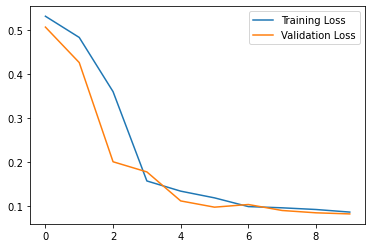

In [10]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()

In [11]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4624      
Total params: 4,944
Trainable params: 4,944
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran multiple                  2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  289       
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


In [13]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
print(tf.squeeze(decoded_data).shape)

(45, 64, 64)


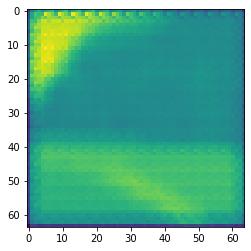

In [14]:
# print(tf.squeeze(decoded_data[0][0]).shape)
plt.imshow(tf.squeeze(decoded_data[0]))
plt.show()

In [15]:
def plotDifferences(test_data, decoded_data, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(tf.squeeze(test_data[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(2, n, i + n + 1)
        plt.imshow(tf.squeeze(decoded_data[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

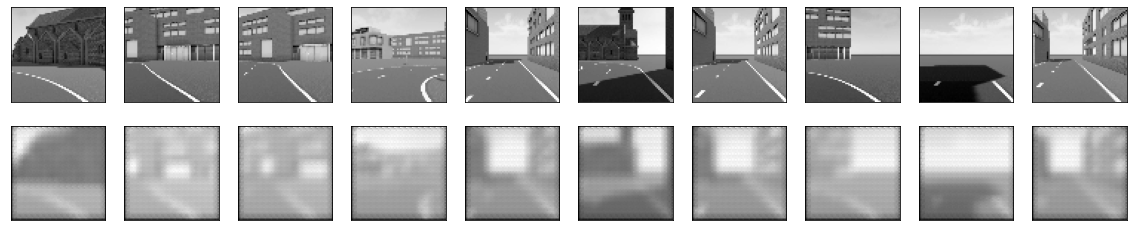

In [16]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plotDifferences(normal_test_data, decoded_data, 10)

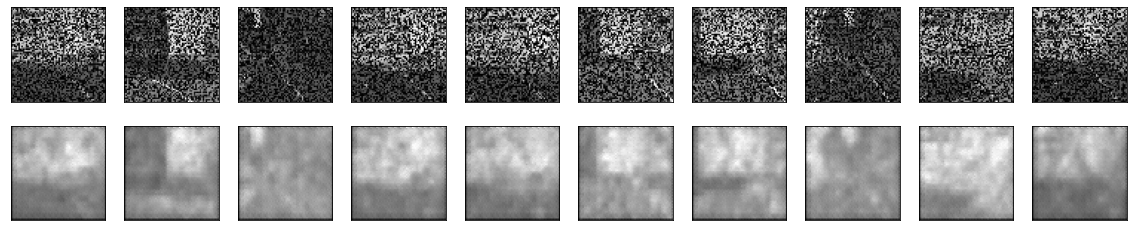

In [17]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plotDifferences(anomalous_test_data, decoded_data, 10)

(176, 64, 64, 1)
(176, 64, 64, 1)
(176, 64, 64)
tf.Tensor(
[[0.17790288 0.10442573 0.04790777 ... 0.06370908 0.08348697 0.13119078]
 [0.16665822 0.10827339 0.0106011  ... 0.01655453 0.0325284  0.09461606]
 [0.1581583  0.06834441 0.00568914 ... 0.00599241 0.01906461 0.09876812]
 ...
 [0.00122434 0.01974294 0.01018837 ... 0.00739631 0.01012781 0.00294614]
 [0.00386217 0.01674268 0.00756794 ... 0.01446825 0.00695521 0.01002857]
 [0.01138899 0.0054222  0.00233823 ... 0.00532386 0.00369579 0.01847711]], shape=(64, 64), dtype=float32)
(1, 176, 64, 64)


ValueError: x must have 2 or fewer dimensions

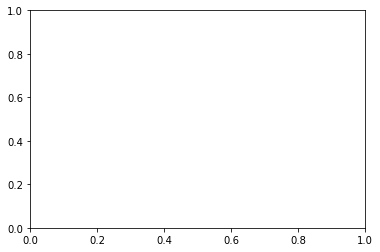

In [110]:
reconstruction = autoencoder.predict(normal_train_data)


print(reconstruction.shape)
print(normal_train_data.shape)
# print(reconstruction)
train_loss = tf.keras.losses.mae(reconstruction, normal_train_data)
print(train_loss.shape)
print(train_loss[0])
print(train_loss[None, :].shape)
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()
